In [1]:
# import required libraries

import pickle
import re

import itertools
import math

import os
import sys

import libsbml
import numpy as np
import pandas as pd
from scipy.stats import percentileofscore
import copy

from Bio import Phylo

from io import StringIO

from scipy.interpolate import interp1d
from scipy.stats import percentileofscore
from scipy.stats import gaussian_kde
import math
import seaborn as sns
import itertools
import plotly.figure_factory as ff
import plotly.io as pio

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

mpl.rcParams['figure.dpi'] = 300
arial_font = fm.FontProperties(fname='arial.ttf')
plt.rcParams['font.family'] = arial_font.get_name()

In [2]:
#%% specify working directory, model path
cd = os.getcwd()
wd = os.path.dirname(cd)
sys.path.append(os.path.join(wd,'bin'))

sbml_file = "SPARCED.xml"


sbml_reader = libsbml.SBMLReader()
sbml_doc = sbml_reader.readSBML(os.path.join(wd,sbml_file))
sbml_model = sbml_doc.getModel()

species_all = [str(x.getId()) for x in list(sbml_model.getListOfSpecies())]

output_dir_main = os.path.join(wd,'output')

exp_title = 'in_silico_drs'
output_main = os.path.join(wd,'output',exp_title)


dir_doses_all = os.listdir(os.path.join(output_main, 'drs_alpel', 'drs_alpel_rep1'))

doses_all = [float(x.split('_')[-1]) for x in dir_doses_all]

doses_all.sort()

# import class for reading dose response outputs

from modules.drsPlotting import drs_dict

In [3]:
#%% load gr score dataframe


drs_all_gr = pd.read_csv(os.path.join(wd,'output','in_silico_drs_summary','drs_grcalc3_grc.tsv'),sep='\t')


In [4]:
#%% define function to read experimental datasets

def read_exp_data(file_name):
    dir_exp = os.path.join(wd,'output','in_silico_drs_summary','mcf10a_drs_exp')
    exp_data = pd.read_csv(os.path.join(dir_exp,file_name),sep=',')
    grv_df = pd.DataFrame()
    grv_df['cell_line'] = exp_data['cell_line']
    
    drugs = exp_data['agent'].values
    
    for d in range(len(drugs)):
        if '/' in drugs[d]:
            drug = str(drugs[d]).split('/')[0]
            drugs[d] = drug
    
    # grv_df['agent'] = exp_data['agent']
    grv_df['agent'] = drugs
    grv_df['concentration'] = exp_data['concentration']
    try:
        grv_df['timepoint'] = exp_data['timepoint']
    except:
        grv_df['timepoint'] = np.ones(len(exp_data['cell_line'].values))*np.nan
    grv_df['cell_count'] = exp_data['cell_count']
    grv_df['cell_count__ctrl'] = exp_data['cell_count__ctrl']
    grv_df['cell_count__time0'] = exp_data['cell_count__time0']
    grv_df['GRvalue'] = exp_data['GRvalue']
    
    return grv_df



In [5]:
#%% load experimental datasets

grv_c1a1 = read_exp_data('GRvalues_center1_scientistA_2017.csv')
grv_c1a2 = read_exp_data('GRvalues_center1_scientistA_2019.csv')
grv_c1b = read_exp_data('GRvalues_center1_scientistB.csv')
grv_c1c = read_exp_data('GRvalues_center1_scientistC.csv')
grv_c2 = read_exp_data('GRvalues_center2.csv')
grv_c3 = read_exp_data('GRvalues_center3.csv')
grv_c4 = read_exp_data('GRvalues_center4.csv')
grv_c5 = read_exp_data('GRvalues_center5.csv')


In [6]:
#%% combine and map exp doses to sim

drugs_exp = ['Alpelisib','Neratinib','Trametinib','Palbociclib']
grv_exp = {'grv_c1a1':grv_c1a1,'grv_c1a2':grv_c1a2,'grv_c1b':grv_c1b,'grv_c1c':grv_c1c,'grv_c2':grv_c2,'grv_c3':grv_c3,'grv_c4':grv_c4,'grv_c5':grv_c5}


grv_exp_df = pd.DataFrame()

for key in grv_exp.keys():
    grv_df = grv_exp[key]
    grv_df['source'] = np.ones(np.shape(grv_df)[0])*np.nan
    grv_df['source'] = key
    grv_exp_df = grv_exp_df.append(grv_df, ignore_index=True)
    

grv_exp_compare = pd.DataFrame()

# grv_c2[math.isclose(grv_c2['concentration'],doses_all[3],abs_tol=1e-4)]

for dose_sim in doses_all[1:]:
    for row_n in range(np.shape(grv_exp_df)[0]):
        grv_exp_row = grv_exp_df.iloc[row_n,:].copy()
        if grv_exp_row['agent'] in drugs_exp:
            if math.isclose(float(grv_exp_row['concentration']),dose_sim,abs_tol=1e-4):
                grv_exp_row['dose_sim'] = dose_sim
                grv_exp_compare = grv_exp_compare.append(grv_exp_row,ignore_index=True)

In [7]:
#%% define plotting function

def gr_compare(drug_compare):

    #drug_compare = drugs_exp[0] # 0~3

    drug_sim = drug_compare.lower()[:5]
   
    grv_exp_drug = grv_exp_compare[grv_exp_compare['agent']==drug_compare]

    x_values = doses_all[1:]

    y_values_all_exp = [grv_exp_drug[grv_exp_drug['dose_sim']==xval]['GRvalue'].values for xval in x_values]

    y_values_median_exp = [np.median(ys) for ys in y_values_all_exp]

    if sum(np.isnan(y_values_median_exp))>0:

        nan_idx = np.where(np.isnan(y_values_median_exp))[0][0]

        x_values_actual = x_values[:nan_idx]
        x_values = x_values_actual

        y_values_all_exp = [grv_exp_drug[grv_exp_drug['dose_sim']==xval]['GRvalue'].values for xval in x_values]

        y_values_median_exp = [np.median(ys) for ys in y_values_all_exp]




    y_min_exp = [np.min(ys) for ys in y_values_all_exp]

    y_max_exp = [np.max(ys) for ys in y_values_all_exp]

    y_err_min_exp = [y_values_median_exp[dl] - y_min_exp[dl] for dl in range(len(y_values_median_exp))]

    y_err_max_exp = [y_max_exp[dl] - y_values_median_exp[dl] for dl in range(len(y_values_median_exp))]

    yerror_exp = [y_err_min_exp,y_err_max_exp]


    #%

    tp = 72

    drs_filtered = drs_all_gr[drs_all_gr['agent']==drug_sim]
    drs_filtered = drs_filtered[drs_filtered['timepoint']==tp]

    y_values_all_sim = [drs_filtered[drs_filtered['concentration']==xval]['GRvalue'].values for xval in x_values]

    y_values_median_sim = [np.median(ys) for ys in y_values_all_sim]

    y_min_sim = [np.min(ys) for ys in y_values_all_sim]

    y_max_sim = [np.max(ys) for ys in y_values_all_sim]

    y_err_min_sim = [y_values_median_sim[dl] - y_min_sim[dl] for dl in range(len(y_values_median_sim))]

    y_err_max_sim = [y_max_sim[dl] - y_values_median_sim[dl] for dl in range(len(y_values_median_sim))]

    yerror_sim = [y_err_min_sim,y_err_max_sim]



    #%

    plt.errorbar(x_values,y_values_median_exp,yerr=yerror_exp,fmt='o-',capsize=5,label='Experiment')
    plt.errorbar(x_values,y_values_median_sim,yerr=yerror_sim,fmt='o-',capsize=5,label='Simulation')

    plt.xscale('log')
    # plt.ylim(min(y_min)*.5,max(y_max)*1.25)
    plt.ylim(-0.5,1.3)
    plt.title(str(drug_compare),font='Arial')
    plt.ylabel('GR value',font='Arial')
    plt.xlabel('Concentration (uM)',font='Arial')
    plt.legend(loc='lower left')
    plt.show()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Ari

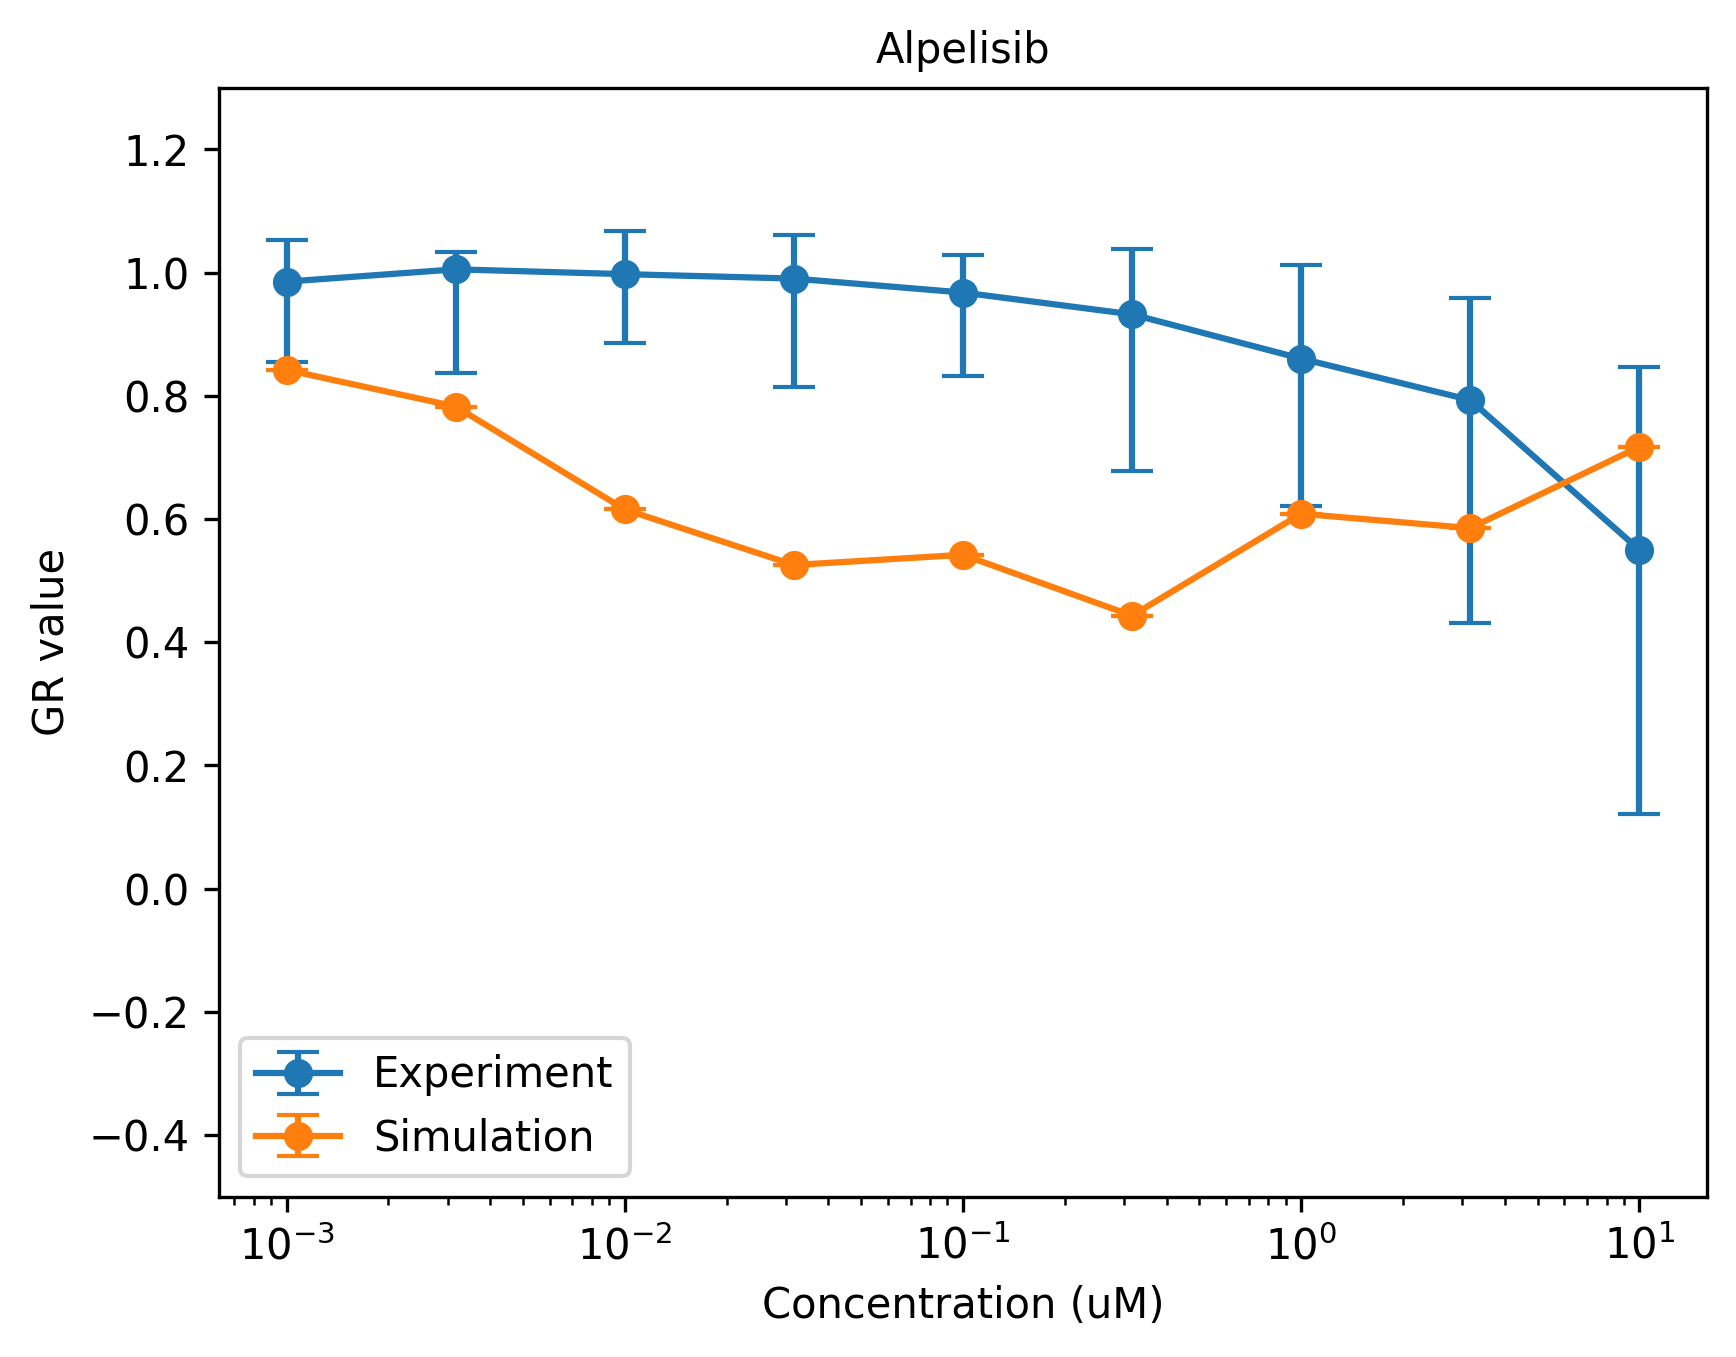

In [8]:
#%% gr score comparison plot for alpelisib (Figure 2d)

gr_compare('Alpelisib')

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

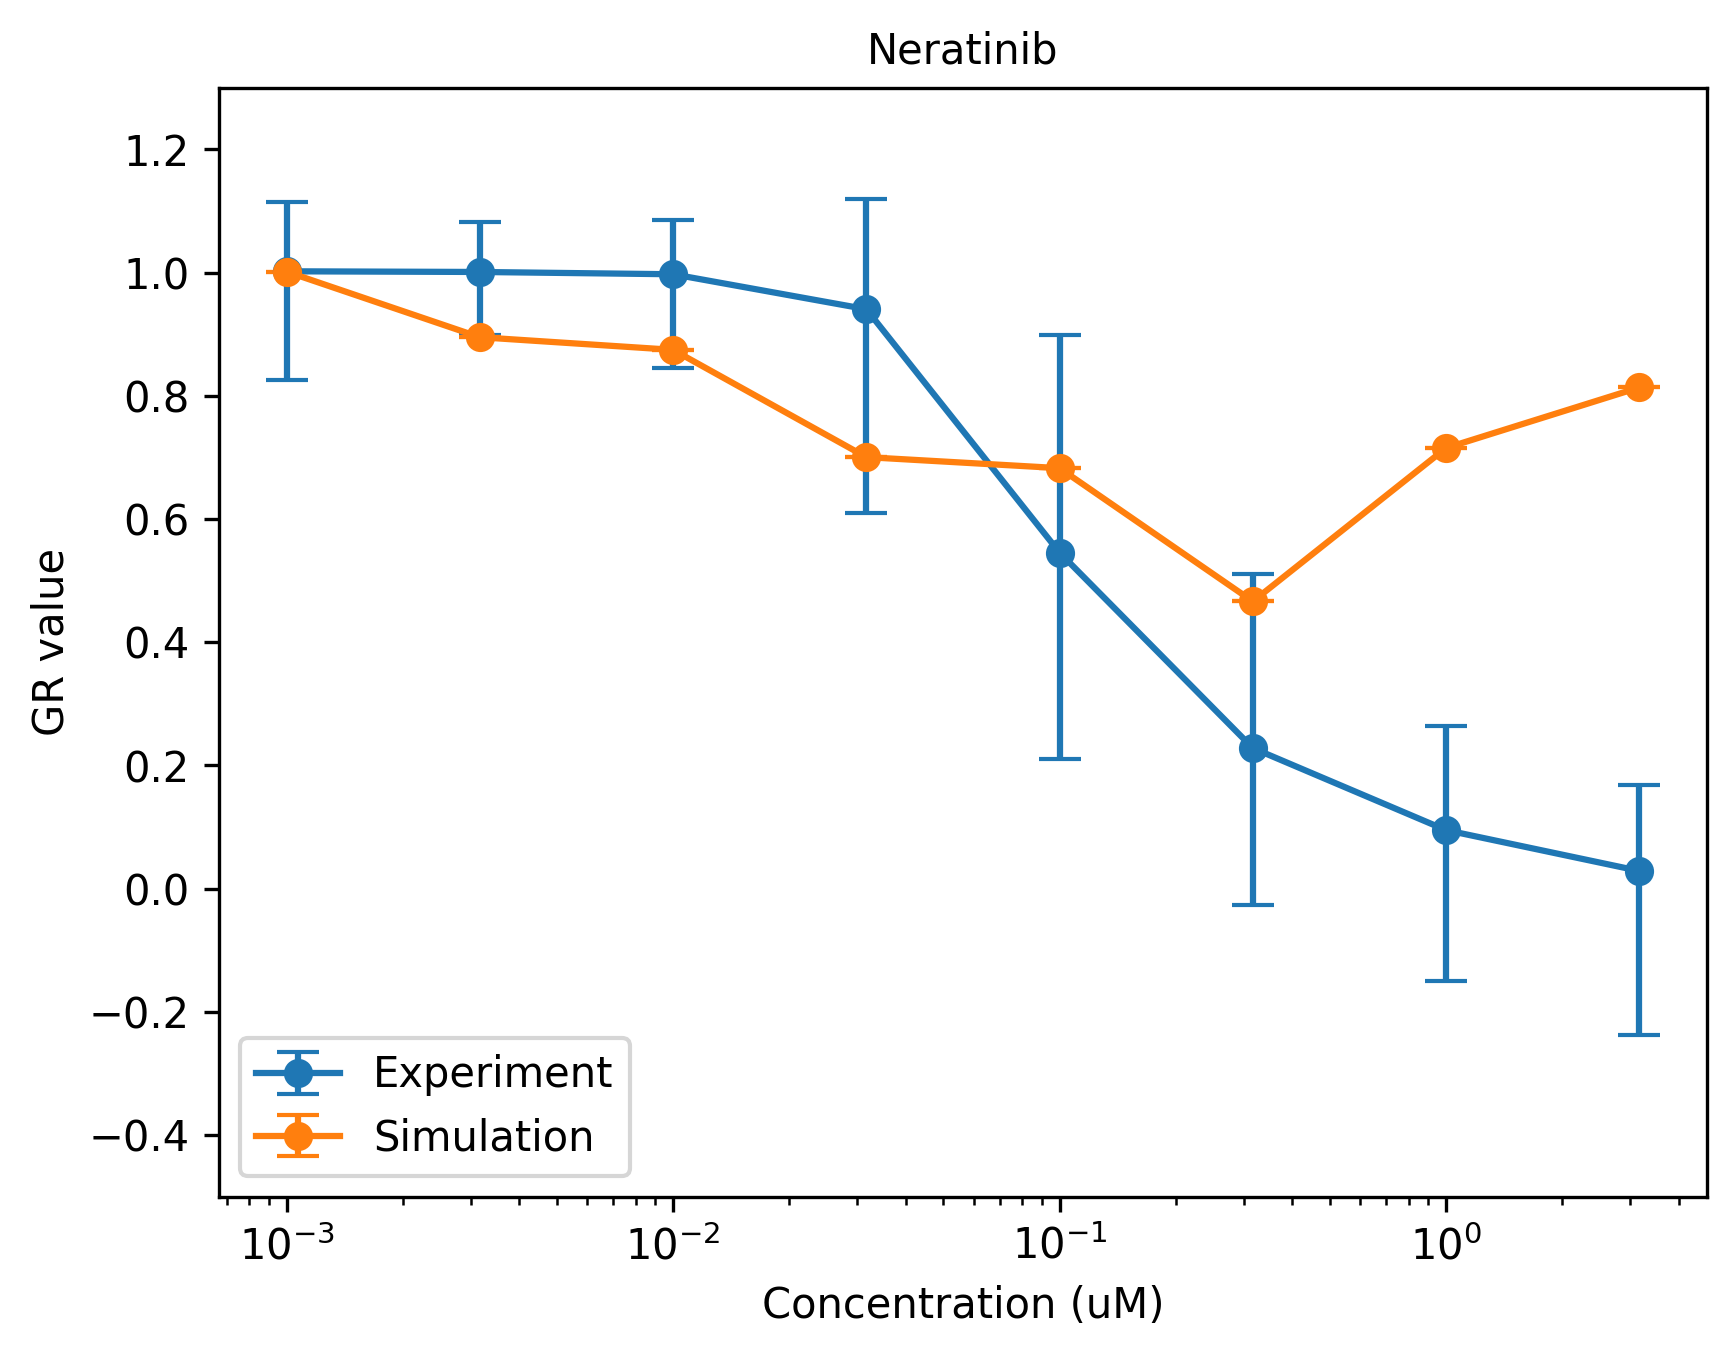

In [9]:
#%% gr score comparison plot for neratinib (Figure 2e)

gr_compare('Neratinib')

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

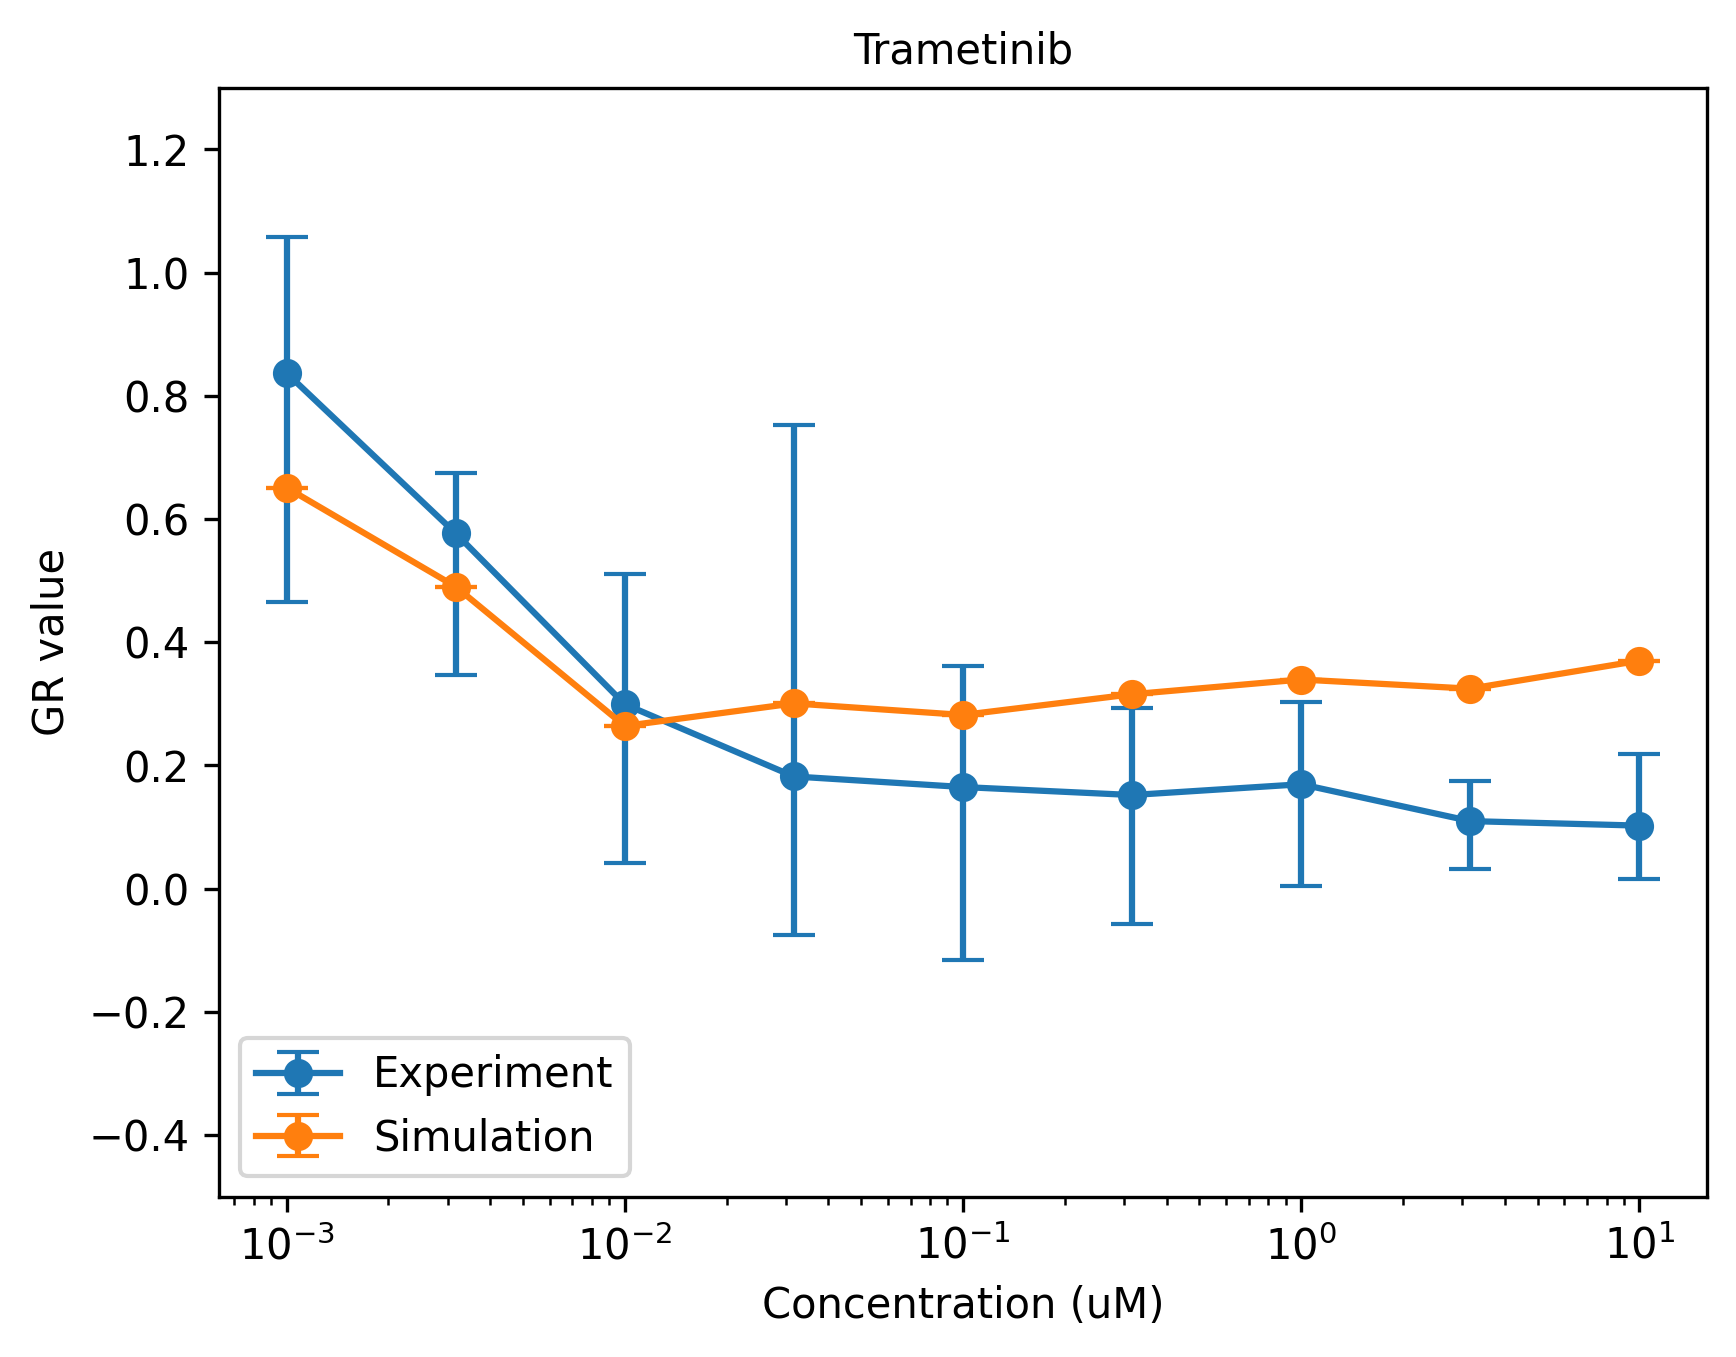

In [10]:
#%% gr score comparison plot for neratinib (Figure 2f)

gr_compare('Trametinib')

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

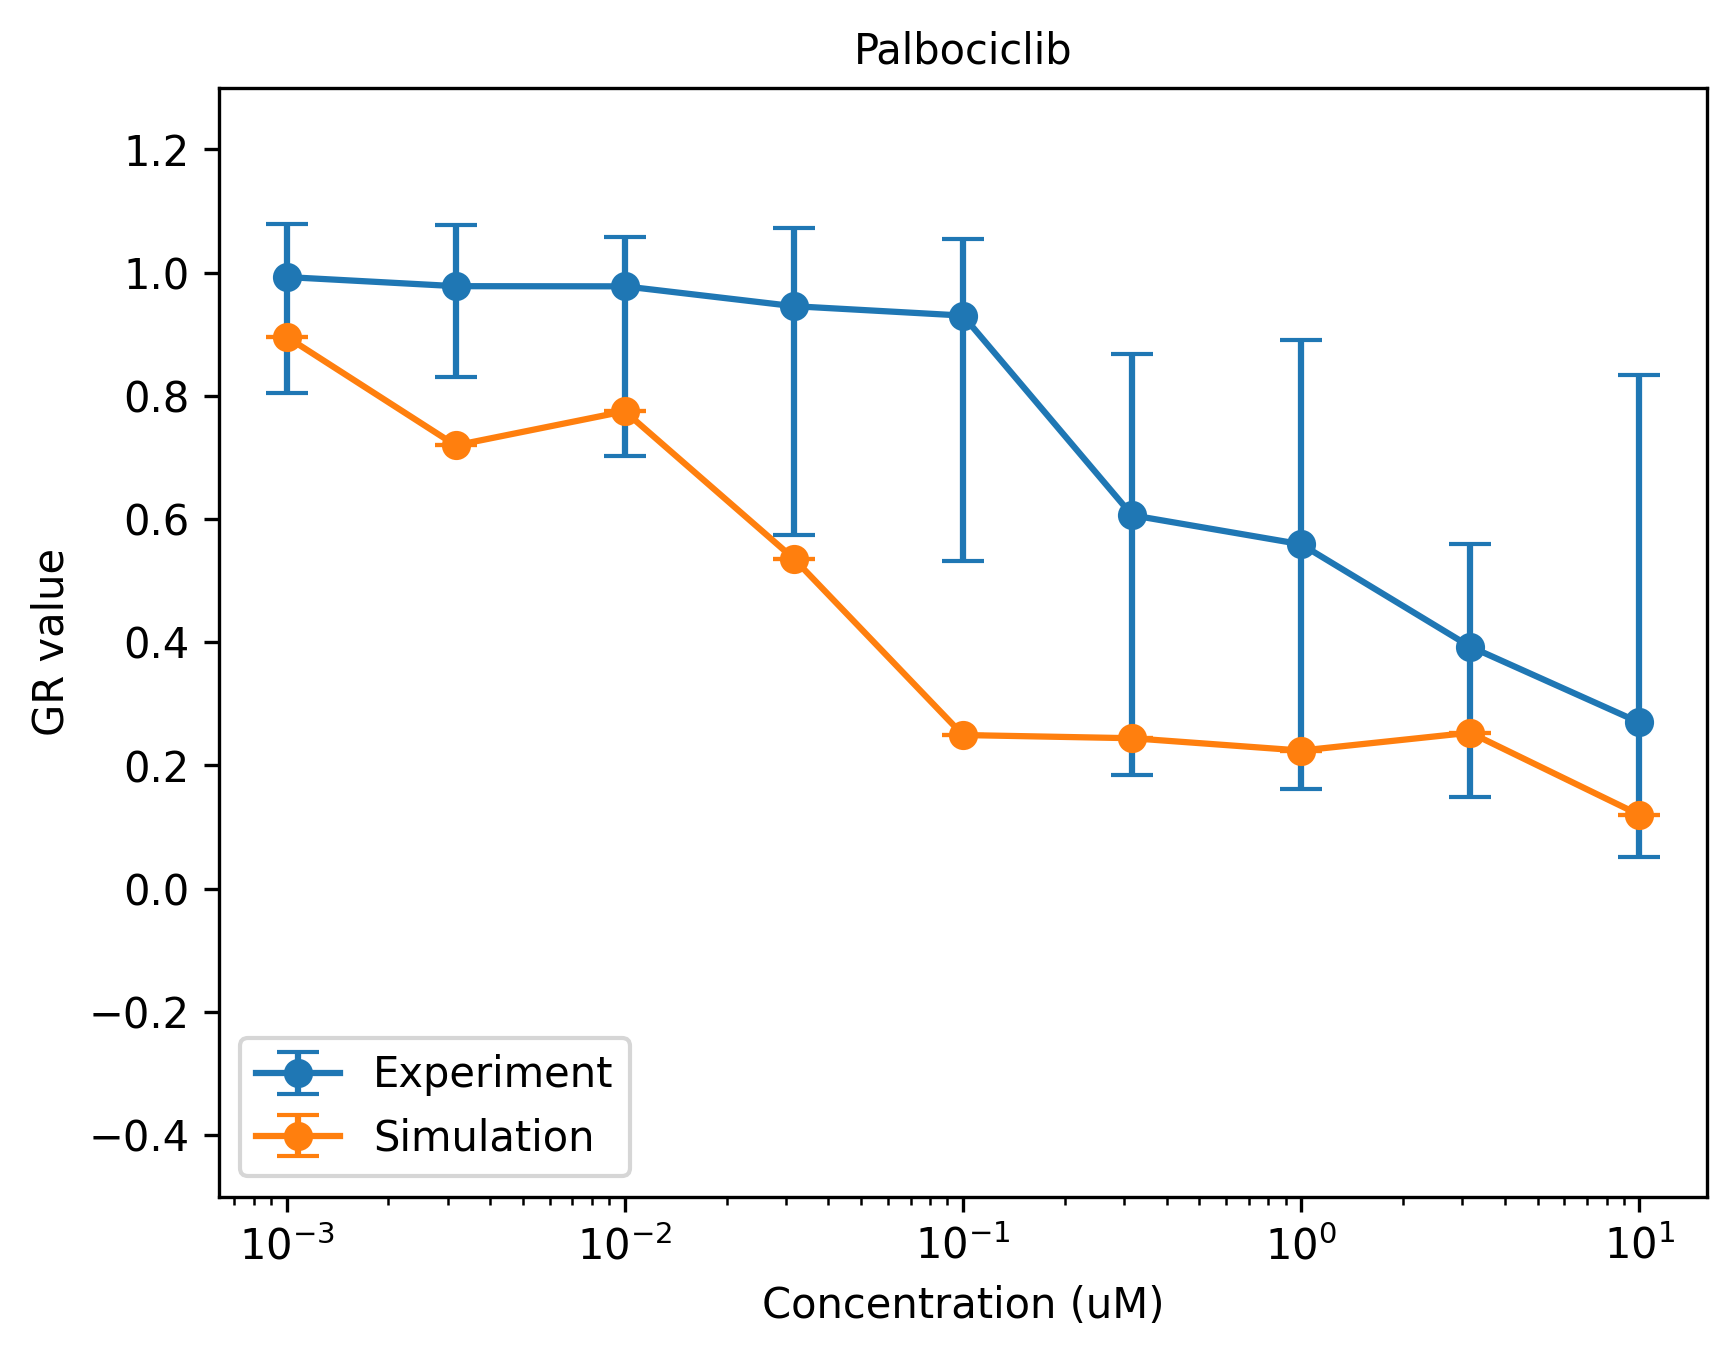

In [11]:
#%% gr score comparison plot for palbociclib (Figure 2g)

gr_compare('Palbociclib')